In [1]:
import time
import json
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


In [2]:

# Path: ae.ipynb
def create_dl_links():
    dl_list =[]
    files = os.listdir("combined")
    for i in range(len(files)):
        with open("combined/" + files[i], "r") as file:
            data = json.load(file)
            for j in range(len(data)):
                date = data[j]["date"].split(" ")
                date.remove(date[-1])
                date = date[0].replace("-", "/")
                img = data[j]["image"] + ".png"
                link = f"https://epic.gsfc.nasa.gov/archive/enhanced/{date}/png/{img}"
                dl_list.append(link)
    return dl_list

list = create_dl_links()


In [3]:
# Set device (Acceleration if available, else CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Set manual seed for reproducibility
torch.manual_seed(2001110219971207)

mps


In [4]:

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            ## nn.Identity(), # Does nothing
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=8,  stride=2, padding=3), # Could be: Padding = (kernel_size - 1) / 2 to retain input size
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=8, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=8, stride=2, padding=3),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            ## nn.Identity(), # Does nothing
            # now trying to reverse the encoder
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=8, stride=2, padding=3),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=8, stride=2, padding=3),
            nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=8, stride=2, padding=3),          
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Analysis of the model
print(summary(Autoencoder(), input_size=(1, 3, 512, 512))) # Static


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 3, 512, 512]          --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 3, 256, 256]          579
│    └─ReLU: 2-2                         [1, 3, 256, 256]          --
│    └─Conv2d: 2-3                       [1, 3, 128, 128]          579
│    └─ReLU: 2-4                         [1, 3, 128, 128]          --
│    └─Conv2d: 2-5                       [1, 3, 64, 64]            579
│    └─ReLU: 2-6                         [1, 3, 64, 64]            --
├─Sequential: 1-2                        [1, 3, 512, 512]          --
│    └─ConvTranspose2d: 2-7              [1, 3, 128, 128]          579
│    └─ConvTranspose2d: 2-8              [1, 3, 256, 256]          579
│    └─ConvTranspose2d: 2-9              [1, 3, 512, 512]          579
Total params: 3,474
Trainable params: 3,474
Non-trainable params: 0
Total mult-

In [5]:

# Hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 30
use_batch_download = False # Download random images

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Initialize the autoencoder and loss function
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

writer = SummaryWriter('runs/ae')

# Visualize the model in TensorBoard 
writer.add_graph(autoencoder, torch.rand(1, 3, 512, 512).to(device)) # Static



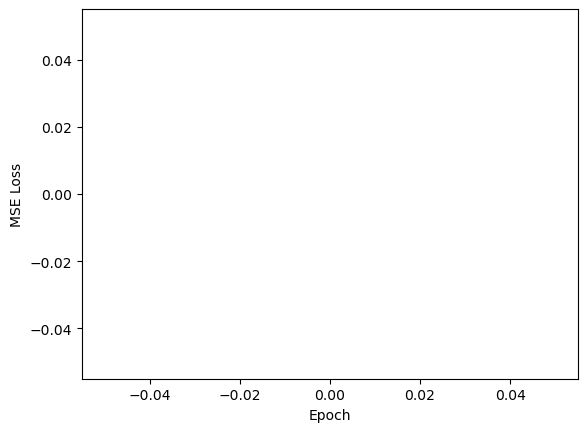

In [6]:
# Training loop
for epoch in range(num_epochs):
    if use_batch_download:
    # Download data and preprocess
        for i in range(batch_size):
            # Download data
            # Pick random image from list
            rand = random.randint(0, len(list))
            os.system(f"wget -P download/earth {list[rand]} --quiet")
        
    # Load data
    dataset = ImageFolder(root='download', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

    for data in dataloader:
        img, _ = data
        img = img.to(device)

        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Prepare the last reconstructed image 
    img_out = output
    img_out = img_out.detach().cpu()
    img_out.detach().numpy()

    # Log losses
    writer.add_scalar("Loss", loss.item(), epoch, time.time())

    # Log input and output images
    writer.add_image("Input", make_grid(img), epoch)
    writer.add_image("Output", make_grid(img_out), epoch)

    # Project image to tensorboard, idk what this does   
    writer.add_embedding(output[0][0], global_step=epoch, tag="Output")

    # Clear download folder
    if use_batch_download:
        os.system("rm download/earth/*")

In [7]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

In [12]:
# load the trained model
model = Autoencoder()
model.load_state_dict(torch.load('autoencoder.pth'))



<All keys matched successfully>